# Gender classification


| Model          | Round 1 | Round 2 | Round 3 |    Average    |
|----------------|:-------:|:-------:|:-------:|:-------------:|
| **ResNet18 + FCN** |   0.96  |   0.95  |   0.95  | **0.95±0.00** |
| ResNet50 + FCN |   0.94  |   0.99  |   0.93  |   0.95±0.03   |

## 1. Image as input

In [3]:
import torch

import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
import torchvision
from torch.optim import lr_scheduler

import os
import numpy as np
import time
import copy

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import sklearn

from livelossplot import PlotLosses

In [4]:
def compute_metrics_pytorch(dataloader, classes, model, report_label='Performance Report', path_to_save=None, sigmoid=False):
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    count = 0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = (data[0].to(device), data[1].to(device))
            outputs = model(inputs)
            if sigmoid:
                predicted = torch.tensor([1 if outputs[i][0] > 0.5 else 0 for i in range(len(outputs))], device=device)
            else:
                _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                if predicted.shape[0] == 1:
                    class_correct[label] += c.item()
                else:
                    class_correct[label] += c[i].item()
                class_total[label] += 1

            if count == 0:
                y_true = labels
                y_pred = predicted
            else:
                y_pred = torch.cat((y_pred, predicted), dim=-1)
                y_true = torch.cat((y_true, labels), dim=-1)

            count += 1

    print(report_label)

    y_true = y_true.cpu()
    y_pred = y_pred.cpu()
    if path_to_save != None:
        report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
        report_dict_file = open(os.path.join(path_to_save), 'w')
        json.dump(report, report_dict_file)
        report_dict_file.close()

    print(classification_report(y_true, y_pred, target_names=classes))
        
    return y_true, y_pred

def create_dataloaders(data_dir, batch_size):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    return dataloaders, class_names, dataset_sizes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [5]:
def plot_confusion_matrix(y_true, y_pred, label_names, path_to_save=None):
    confusion_mtx = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, xticklabels=label_names, yticklabels=label_names, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    if path_to_save != None:
        plt.savefig(path_to_save)

In [6]:
def ResNet18(num_classes, pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    model.conv1 = nn.Conv2d(1, model.conv1.out_channels, 
                        kernel_size=model.conv1.kernel_size[0], 
                        stride=model.conv1.stride[0], 
                        padding=model.conv1.padding[0])
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

In [30]:
data_dir = 'data/PETA dataset/gc2'
dataloaders, class_names, dataset_sizes = create_dataloaders(data_dir=data_dir, batch_size=16)

In [31]:
dataset_sizes

{'train': 7640, 'val': 1912}

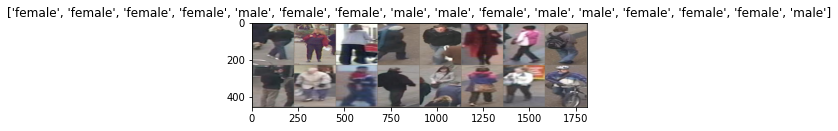

In [32]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[int(x)] for x in classes])

In [33]:
def train_model(dataloaders, model, dataset_sizes, criterion, optimizer, scheduler=None, num_epochs=25, cw=None, sigmoid=False):
    
    liveloss = PlotLosses()
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        logs = {}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
            

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if sigmoid:
                        preds = torch.tensor([1 if outputs[i][0] > 0.5 else 0 for i in range(len(outputs))], device=device)
                        if cw is None:
                            loss = criterion(torch.reshape(outputs, (-1,)), labels.to(torch.float32).to(device), reduction='sum')
                        else:
                            loss = criterion(torch.reshape(outputs, (-1,)), labels.to(torch.float32).to(device), weights=cw)
                    else:
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.cpu().item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).cpu()
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            prefix = ''
            if phase == 'train':
                pass
            else:
                prefix = 'val_'

            logs[prefix + 'loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        liveloss.update(logs)
        liveloss.send()

    time_elapsed = time.time() - since

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [34]:
# Resnet18
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = None

epoch = 100

model_ft = train_model(
    dataloaders=dataloaders, 
    model=model_ft, 
    dataset_sizes=dataset_sizes, 
    criterion=criterion, 
    optimizer=optimizer_ft, 
    scheduler=exp_lr_scheduler, 
    num_epochs=epoch,
    sigmoid=False,
)

accuracy
	training         	 (min:    0.647, max:    0.988, cur:    0.988)
	validation       	 (min:    0.674, max:    0.926, cur:    0.910)
Loss
	training         	 (min:    0.034, max:    0.630, cur:    0.034)
	validation       	 (min:    0.238, max:    0.598, cur:    0.364)


In [ ]:
# model_name = 'resnet50_100ep_ce_shuffle2.pth'
# PATH = os.path.join('models', model_name)
# torch.save(model_ft.state_dict(), PATH)

In [47]:
# Load model for inference
model_name = 'resnet50_100ep_ce_shuffle3.pth'
PATH = os.path.join('models', model_name)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
y_true, y_pred = compute_metrics_pytorch(dataloaders['val'], class_names, model, sigmoid=False)
plot_confusion_matrix(y_true, y_pred, '')

Performance Report
              precision    recall  f1-score   support

      female       0.94      0.92      0.93      1023
        male       0.91      0.93      0.92       889

    accuracy                           0.93      1912
   macro avg       0.93      0.93      0.93      1912
weighted avg       0.93      0.93      0.93      1912



In [55]:
# list_acc = [0.94, 0.99, 0.93]

# print(f'{np.average(list_acc):.2f}±{np.std(list_acc):.2f}')